In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Extraction

In [2]:
#!unzip '/content/drive/MyDrive/DataML.zip'
#!unrar x '/content/drive/MyDrive/Image_Dataset1.rar'
#!unzip '/content/drive/MyDrive/GaussAug_data.zip'

## Imports


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import glob
import torch
from torch import optim
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from matplotlib import image as img
from tensorflow.keras.utils import to_categorical
import pickle
from scipy import signal
import skimage.measure
from sklearn.model_selection import train_test_split
from numba import cuda
import torchvision # load datasets
from torchvision import datasets, transforms, models
import torch.utils.data as data


## Data Augumentation

In [4]:

"""transform = transforms.Compose( # composing several transforms together
         [transforms.ToTensor(),transforms.Resize((64,64))])
data = datasets.ImageFolder('Image_Dataset1',transform=transform)
#train_loader = torch.utils.data.DataLoader(data, batch_size=32)
arr=[]
for i in data.classes:
    arr.append(i)
for l in arr:
  print(l)
  for img, label in data:
          if (arr[label]==l):
                print(l)
img_num = 30000
arr=[]
for i in data.classes:
    arr.append(i)
print(arr[0])
for l in arr:
    print(l)
  for img, label in data:
      if (img)
      gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=1, clip=True))
      torchvision.utils.save_image(gauss_img, 'Image_Dataset1/'+l+'/'+str(img_num)+'.jpg')
      img_num += 1"""

"transform = transforms.Compose( # composing several transforms together\n         [transforms.ToTensor(),transforms.Resize((64,64))])\ndata = datasets.ImageFolder('Image_Dataset1',transform=transform)\n#train_loader = torch.utils.data.DataLoader(data, batch_size=32)\narr=[]\nfor i in data.classes:\n    arr.append(i)\nfor l in arr:\n  print(l)\n  for img, label in data:\n          if (arr[label]==l):\n                print(l)\nimg_num = 30000\narr=[]\nfor i in data.classes:\n    arr.append(i)\nprint(arr[0])\nfor l in arr:\n    print(l)\n  for img, label in data:\n      if (img)\n      gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=1, clip=True))\n      torchvision.utils.save_image(gauss_img, 'Image_Dataset1/'+l+'/'+str(img_num)+'.jpg')\n      img_num += 1"

## Loading Dataset

In [5]:
def loadDataset(batch_size,shuffle):

         transform = transforms.Compose( # composing several transforms together
         [transforms.ToTensor(),transforms.Resize((64,64))])
         #transforms.Normalize((0.7545, 1.0180, 1.1397), (0.5418, 0.4986, 0.4878)) # mean = 0.5, std = 0.5
         train_data = datasets.ImageFolder('content/Image_Dataset1', transform=transform)
         train_set_size = int(len(train_data) * 0.9)
         val_set_size = len(train_data) - train_set_size
         train_set, val_set =data.random_split(train_data, [train_set_size, val_set_size])
         val_set_size = int(len(val_set) * 0.7)
         test_set_size = len(val_set) - val_set_size
         val_set,test_set =data.random_split(val_set, [val_set_size, test_set_size])
         train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle,num_workers=2,pin_memory=True)
         val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=shuffle,num_workers=2,pin_memory=True)
         test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=shuffle,num_workers=2,pin_memory=True)
           
         return train_loader,val_loader,test_loader

In [6]:
train_loader,val_loader,test_loader=loadDataset(32,True)
print("Train:{} Validation:{} Test:{}".format(len(train_loader),len(val_loader),len(test_loader)))


Train:676 Validation:53 Test:23


## Normalizing Data

In [7]:
def Normalization():
        mean = 0.
        std = 0.
        for images, _ in train_loader:
            batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= len(train_loader.dataset)
        std /= len(train_loader.dataset)
        return mean,std

In [8]:
#mean,std=Normalization()

## Data Representation

In [9]:
def showImage(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.figure(figsize=(20,10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Training Data Representation

torch.Size([32, 3, 64, 64])


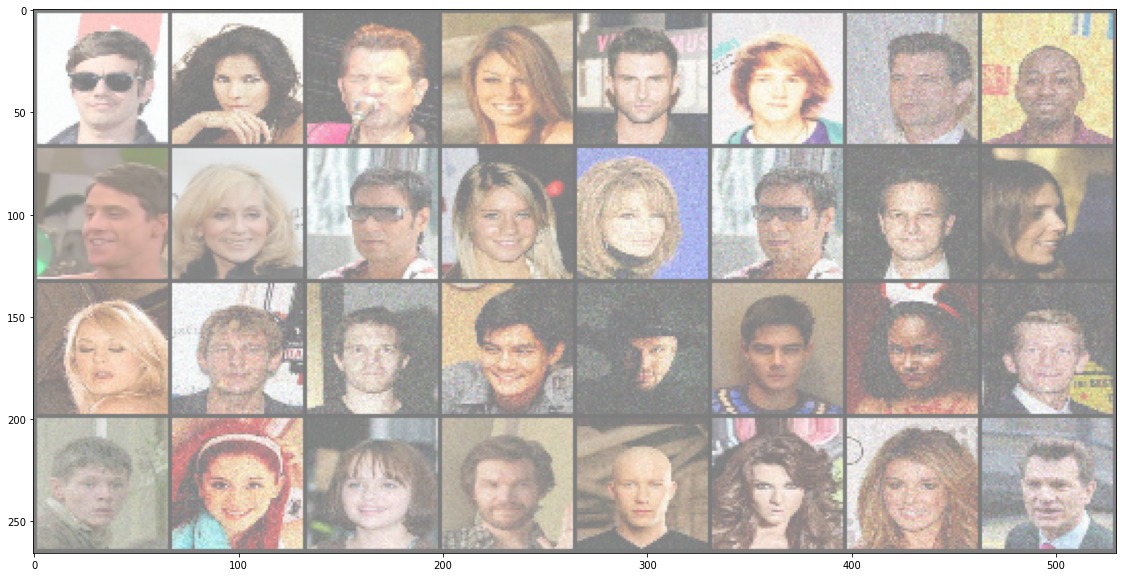

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
showImage(torchvision.utils.make_grid(images))

## Testing data Representation

torch.Size([32, 3, 64, 64])


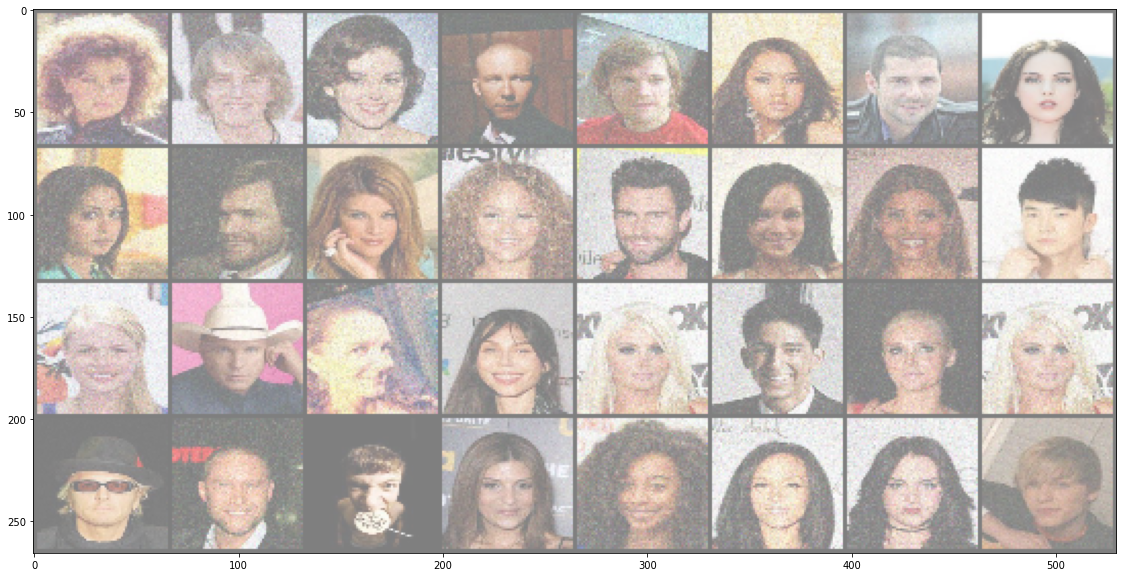

In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(images.shape)
showImage(torchvision.utils.make_grid(images))

## Network

In [12]:
class FaceRecognitionNet(nn.Module):
    def __init__(self):
        super(FaceRecognitionNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16,32, 5, stride=2, padding=1)
        
        self.fc1 = nn.Linear(1568,1024)  
        self.fc2 = nn.Linear(1024,512)  
        self.fc3 = nn.Linear(512, 100)  

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net=FaceRecognitionNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

FaceRecognitionNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

## Model Training

In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [15]:
def train(net, training_data,validation_data,epochs,criterion,optimizer,validation):
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 train_loss=[]
 train_accuracy=[]
 val_acc=[]
 val_loss=[]
 for epoch in range(epochs):
    loss_=0
    correct=0
    total=0
    for batch, (data, target) in enumerate(training_data):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)        
        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        loss_+=loss.item()
        predicted = torch.max(out.data, 1)[1]
        total += target.size(0)
        correct += (predicted ==target).sum()
          
    train_loss.append(loss_/len(training_data))
    train_accuracy.append(correct / float(total))
    print('Train Epoch: {} \tLoss: {}\tAccuracy: {}'.format( epoch, loss.item(),100*(correct / float(total))))
    if validation==True:
               total_val=0
               correct_val=0
               v_loss=0
               for batch_v,(datav,targetv) in enumerate(validation_data, 0):
                    datav, targetv = Variable(datav), Variable(targetv)
                    datav, targetv = datav.to(device), targetv.to(device)        
                    v_out = net(datav)
                    lossv= criterion(v_out,targetv)
                    predicted_val = torch.max(v_out.data, 1)[1]
                    total_val += len(targetv)
                    correct_val += (predicted_val == targetv).sum()
                    v_loss += lossv.item()
               val_loss.append(v_loss/len(validation_data))
               val_acc.append(correct_val / float(total_val))
               print('Validation Epoch: {} \tLoss: {}\tAccuracy: {}'.format( epoch, lossv.item(),100*(correct_val / float(total_val))))
          
 return train_loss,train_accuracy ,val_loss,val_acc

In [16]:
train_loss,train_accuracy,val_loss,val_acc=train(net,train_loader,test_loader,12,criterion,optimizer,True)


Train Epoch: 0 	Loss: 4.610320568084717	Accuracy: 1.3690394163131714
Validation Epoch: 0 	Loss: 4.607037544250488	Accuracy: 0.6934813261032104
Train Epoch: 1 	Loss: 4.568778038024902	Accuracy: 1.3551640510559082
Validation Epoch: 1 	Loss: 4.611164093017578	Accuracy: 2.080443859100342
Train Epoch: 2 	Loss: 3.7791802883148193	Accuracy: 4.555756092071533
Validation Epoch: 2 	Loss: 3.445502519607544	Accuracy: 10.26352310180664
Train Epoch: 3 	Loss: 3.6011478900909424	Accuracy: 13.209380149841309
Validation Epoch: 3 	Loss: 3.2778079509735107	Accuracy: 16.643550872802734
Train Epoch: 4 	Loss: 3.1791799068450928	Accuracy: 23.685306549072266
Validation Epoch: 4 	Loss: 2.407224655151367	Accuracy: 29.680999755859375
Train Epoch: 5 	Loss: 2.382632255554199	Accuracy: 36.95943832397461
Validation Epoch: 5 	Loss: 2.0225493907928467	Accuracy: 43.966712951660156
Train Epoch: 6 	Loss: 1.240358829498291	Accuracy: 54.016929626464844
Validation Epoch: 6 	Loss: 1.3180747032165527	Accuracy: 61.8585357666015

## Model Testing

In [25]:
PATH = '/content/drive/MyDrive/MLModel/task_CNNtask2BestModel.pth'
torch.save(net.state_dict(), PATH)

In [20]:
net =FaceRecognitionNet()
net.load_state_dict(torch.load(PATH))
Classes=test_loader.dataset.indices
Classes

[1245,
 281,
 82,
 730,
 1985,
 2025,
 370,
 921,
 374,
 148,
 669,
 2291,
 761,
 872,
 1968,
 1505,
 1114,
 178,
 1091,
 125,
 1921,
 1956,
 2133,
 446,
 1983,
 771,
 458,
 1316,
 988,
 609,
 750,
 1730,
 2212,
 1756,
 1575,
 579,
 2266,
 1777,
 846,
 1027,
 187,
 16,
 882,
 2097,
 75,
 1874,
 1619,
 1037,
 529,
 1878,
 687,
 24,
 330,
 848,
 562,
 963,
 690,
 1907,
 1875,
 1350,
 678,
 1648,
 816,
 1564,
 875,
 1149,
 2003,
 26,
 2261,
 1538,
 620,
 939,
 1535,
 1503,
 535,
 991,
 1609,
 279,
 736,
 343,
 2216,
 204,
 1881,
 1046,
 630,
 22,
 823,
 1807,
 2180,
 781,
 541,
 1530,
 1336,
 2148,
 661,
 1264,
 1064,
 1504,
 61,
 1454,
 912,
 509,
 478,
 1519,
 2340,
 56,
 502,
 635,
 28,
 1227,
 296,
 1106,
 1696,
 2359,
 368,
 787,
 2321,
 1578,
 1888,
 1621,
 264,
 1233,
 387,
 1780,
 8,
 1913,
 688,
 2168,
 1095,
 1832,
 2178,
 1989,
 286,
 793,
 2126,
 1413,
 844,
 2292,
 1479,
 1422,
 911,
 322,
 942,
 1638,
 1235,
 778,
 2170,
 753,
 339,
 305,
 218,
 1267,
 2120,
 542,
 701,
 234

In [21]:
def test(test_loader):
        corr = 0
        total = 0
        with torch.no_grad():
            for images,targets in test_loader:
                output = net(images)
                _, prediction = torch.max(output.data, 1)
                total += targets.size(0)
                corr += (prediction== targets).sum().item()
        print('Accuracy of the model on all test Data: %d %%' % ( 100 * corr / total))
        return prediction,targets

In [51]:
pred,tar=test(test_loader)
pred,tar

Accuracy of the model on all test Data: 100 %


(tensor([60, 53, 53, 84, 67, 96, 85, 25, 89, 33, 50,  6, 74, 91, 44, 50, 53]),
 tensor([60, 53, 53, 84, 67, 96, 85, 25, 89, 33, 50,  6, 74, 91, 44, 50, 53]))

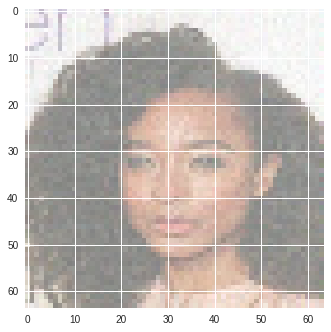

GroundTruth : 12 
 Prediction : 12


In [40]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()
img=images[2]
label=labels[2]
imshow(torchvision.utils.make_grid(img))

#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))
output=net(img.view(1, img.shape[0],img.shape[1], img.shape[2]))
_, predicted = torch.max(output, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(32)))
print('GroundTruth : {} \n Prediction : {}'.format(label.item(),predicted.item()))

In [32]:
corr_pred = {className: 0 for className in Classes}
total_pred = {className: 0 for className in Classes}
with torch.no_grad():
    for images,labels in test_loader:
        output = net(images)
        _, predictions = torch.max(output, 1)
        for label, pred in zip(labels, predictions):
            if label == pred:
                corr_pred[Classes[label]] += 1
            total_pred[Classes[label]] += 1
count=0
for className, corr_count in corr_pred.items():
    count=count+1
    if (count<=100):
            acc= 100 * float(corr_count) / total_pred[className]
            print("Accuracy of class {:5} is: {:.1f} %".format(className,acc))

Accuracy of class  1245 is: 100.0 %
Accuracy of class   281 is: 100.0 %
Accuracy of class    82 is: 100.0 %
Accuracy of class   730 is: 100.0 %
Accuracy of class  1985 is: 100.0 %
Accuracy of class  2025 is: 100.0 %
Accuracy of class   370 is: 100.0 %
Accuracy of class   921 is: 100.0 %
Accuracy of class   374 is: 100.0 %
Accuracy of class   148 is: 100.0 %
Accuracy of class   669 is: 100.0 %
Accuracy of class  2291 is: 100.0 %
Accuracy of class   761 is: 100.0 %
Accuracy of class   872 is: 100.0 %
Accuracy of class  1968 is: 100.0 %
Accuracy of class  1505 is: 100.0 %
Accuracy of class  1114 is: 100.0 %
Accuracy of class   178 is: 100.0 %
Accuracy of class  1091 is: 100.0 %
Accuracy of class   125 is: 100.0 %
Accuracy of class  1921 is: 100.0 %
Accuracy of class  1956 is: 100.0 %
Accuracy of class  2133 is: 100.0 %
Accuracy of class   446 is: 100.0 %
Accuracy of class  1983 is: 100.0 %
Accuracy of class   771 is: 100.0 %
Accuracy of class   458 is: 100.0 %
Accuracy of class  1316 is: 

## Visualization

In [47]:
def visualize_plots(epochs,train_loss,valid_accuracy,train_acc,valid_loss,predictions,targets):
    epochs_= list(range(epochs))

    fig_size = (13, 11)
    fig, axes = plt.subplots(2, 2, figsize=fig_size)

    plt.style.use('seaborn')
    plt.subplot(221)
    plt.plot(epochs_,train_loss)
    plt.title("Epochs Vs Train Loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss per epoch")


    plt.subplot(222)
    plt.plot(epochs_,valid_accuracy)
    plt.title("Epochs Vs Validation Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy per epoch")

    plt.subplot(223)
    plt.plot(epochs_,train_acc)
    plt.title("Epochs Vs Train Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Accuracy per epoch")


    plt.subplot(224)
    plt.plot(epochs_,valid_loss)
    plt.title("Epochs Vs Validation loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Validation loss per epoch")
    recall = recall_score(targets,predictions,average='macro', labels=np.unique(predictions))
    pre = precision_score(targets,predictions,average='macro', labels=np.unique(predictions))
    f = f1_score(targets,predictions,average='macro', labels=np.unique(predictions))
    print("Recall:",recall)
    print("Precision:",pre)
    print("F-Score:",f)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


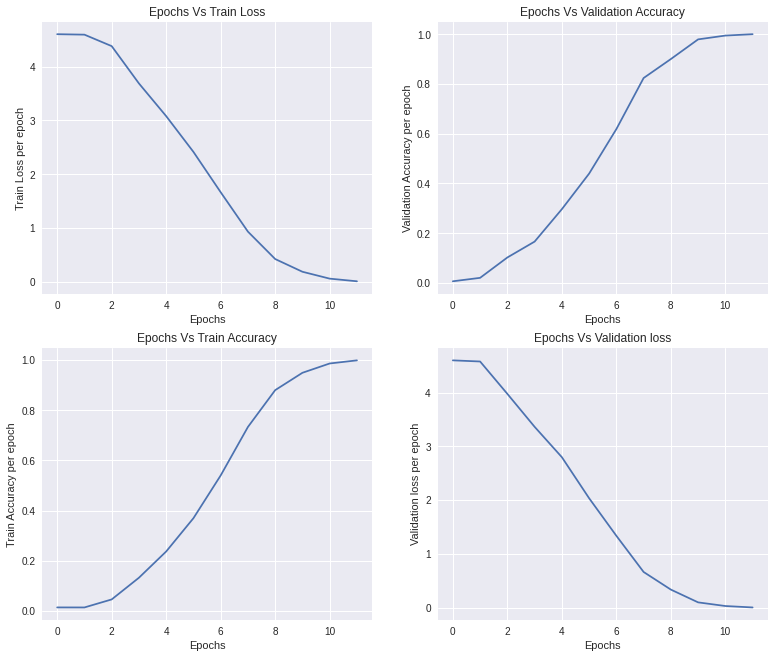

In [52]:
visualize_plots(12,train_loss,val_acc,train_accuracy,val_loss,pred,tar)


## Confuion Matrix

In [53]:
from sklearn.metrics import confusion_matrix,classification_report
def confusion_matrix_plot(targets,predictions):
        cf_matrix = confusion_matrix(targets,predictions)
        plt.figure(figsize = (16,16))
        sns.heatmap(cf_matrix, annot=True)

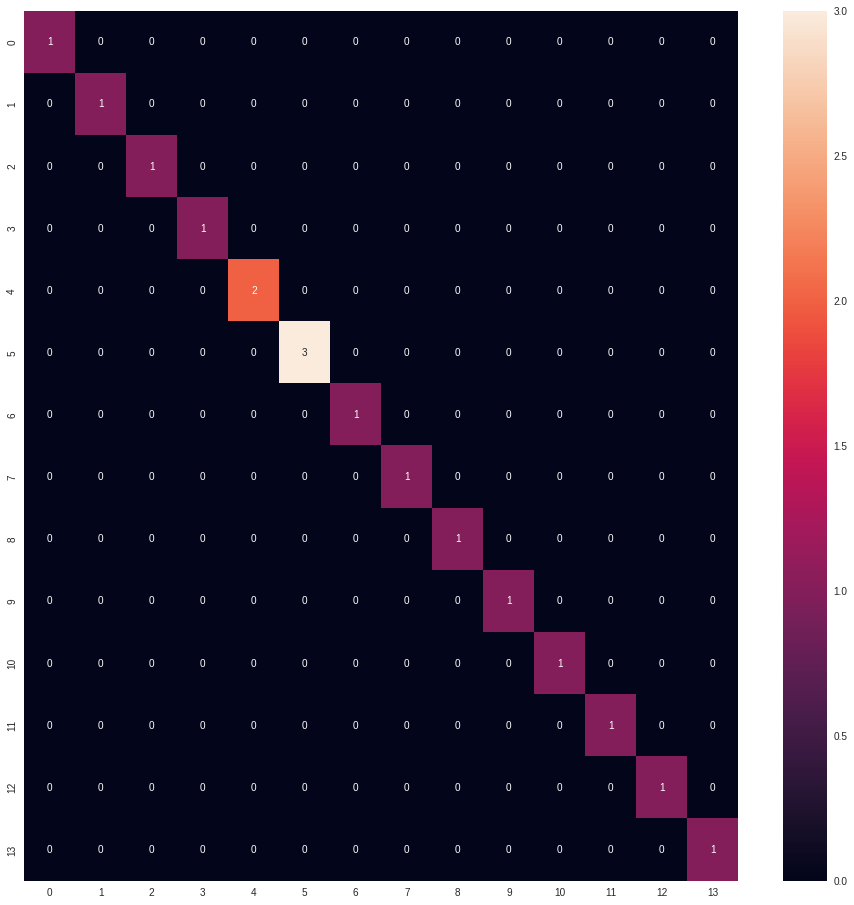

In [54]:
confusion_matrix_plot(tar,pred)